## Reproducing the subsampling analysis

In [1]:
import sys
sys.path.append('../')

from kgwas import KGWAS_Data
from kgwas.eval_utils import get_clumps_gold_label, get_meta_clumps, get_mega_clump_query, get_curve
from tqdm import tqdm
import pandas as pd
import numpy as np

data_path = '/dfs/project/datasets/20220524-ukbiobank/data/kgwas_data/'
data = KGWAS_Data(data_path = data_path)

All required data files are present.


In [2]:
data.get_pheno_list()['21_indep_traits']

['body_BALDING1',
 'disease_ALLERGY_ECZEMA_DIAGNOSED',
 'disease_HYPOTHYROIDISM_SELF_REP',
 'pigment_SUNBURN',
 '21001',
 '50',
 '30080',
 '30070',
 '30010',
 '30000',
 'biochemistry_AlkalinePhosphatase',
 'biochemistry_AspartateAminotransferase',
 'biochemistry_Cholesterol',
 'biochemistry_Creatinine',
 'biochemistry_IGF1',
 'biochemistry_Phosphate',
 'biochemistry_Testosterone_Male',
 'biochemistry_TotalBilirubin',
 'biochemistry_TotalProtein',
 'biochemistry_VitaminD',
 'bmd_HEEL_TSCOREz']

In [3]:
pd.read_csv(data_path + 'model_pred/subsample_results/body_BALDING1_gwas_2500.csv')

,ID,P_seed1,P_seed2,P_seed3,P_seed4,P_seed5
0,rs3131962,0.769574,0.317521,0.179855,0.524405,0.449508
1,rs12562034,0.096443,0.662786,0.863633,0.711095,0.101351
2,rs4040617,0.700440,0.289914,0.230769,0.455915,0.471616
3,rs79373928,0.552305,0.477996,0.006953,0.169693,0.749829
4,rs11240779,0.810017,0.556670,0.291907,0.833291,0.223999
...,...,...,...,...,...,...
536541,rs73174435,0.312853,0.730114,0.870168,0.409637,0.345601
536542,rs3810648,0.623566,0.984208,0.461422,0.711653,0.931965
536543,rs5771002,0.131033,0.890363,0.700539,0.513670,0.429219
536544,rs3865764,0.831915,0.794813,0.914937,0.659038,0.814384


In [4]:
pd.read_csv(data_path + f'full_gwas/body_BALDING1_with_rel_fastgwa.fastGWA', sep = '\t')

,CHR,SNP,POS,A1,A2,N,AF1,BETA,SE,P
0,1,rs3131962,756604,A,G,407023,0.129655,0.000286,0.001048,0.784760
1,1,rs12562034,768448,A,G,407057,0.104966,-0.001491,0.001147,0.193592
2,1,rs4040617,779322,G,A,406623,0.127520,0.000108,0.001056,0.918404
3,1,rs79373928,801536,G,T,407517,0.014884,0.004382,0.002904,0.131349
4,1,rs11240779,808631,G,A,404493,0.224886,-0.001155,0.000846,0.172345
...,...,...,...,...,...,...,...,...,...,...
542753,22,rs73174435,51174939,T,C,407201,0.053846,-0.001980,0.001559,0.203959
542754,22,rs3810648,51175626,G,A,404901,0.060979,0.001922,0.001474,0.192116
542755,22,rs5771002,51183255,A,G,401398,0.333603,-0.000165,0.000751,0.826494
542756,22,rs3865764,51185848,G,A,406611,0.050601,-0.001311,0.001605,0.413994


In [5]:
frac_list = [1000, 2500, 5000, 7500, 10000]
snp_info = pd.read_csv(data_path + 'misc_data/snp_qc_info.csv')
t_p = 5e-8
seed_res = {}
for seed in [1,2,3,4,5]:
    def get_res(query_disease):
        frac2res_all = {}    
        gold_label_gwas = pd.read_csv(data_path + f'full_gwas/{query_disease}_with_rel_fastgwa.fastGWA', sep = '\t')
        gold_label_gwas = gold_label_gwas[~((gold_label_gwas.CHR == 6) & (gold_label_gwas.POS > 28477797) & (gold_label_gwas.POS < 33448354))]

        for frac in tqdm(frac_list):
            base_gwas = pd.read_csv(data_path + f'model_pred/subsample_results/{query_disease}_gwas_{frac}.csv')[['ID', f'P_seed{seed}']].rename(columns = {'ID': 'SNP', f'P_seed{seed}': 'P'})
            kgwas = pd.read_csv(data_path + f'model_pred/subsample_results/{query_disease}_kgwas_{frac}.csv')[['ID', f'P_seed{seed}']].rename(columns = {'ID': 'SNP', f'P_seed{seed}': 'P'})
            findor = pd.read_csv(data_path + f'model_pred/subsample_results/{query_disease}_findor_{frac}.csv')[['SNP', f'P_seed{seed}']].rename(columns = {f'P_seed{seed}': 'P'})
            
            base_gwas = snp_info.merge(base_gwas)
            kgwas = snp_info.merge(kgwas)
            findor = snp_info.merge(findor)
            
            frac2res_frac = {}
            gold_snps = gold_label_gwas[gold_label_gwas.P < t_p].SNP.values

            clumps = get_clumps_gold_label(data_path, gold_label_gwas, t_p = t_p, no_hla = True) 
            idx2mega_clump, idx2mega_clump_rsid, idx2mega_clump_chrom = get_meta_clumps(clumps, data_path) ## filtering cM
            mega_clump_gold = [j for i,j in idx2mega_clump_rsid.items()]
            
            def get_scores(base_gwas, name):
                frac2res = {}
                base_gwas['logp'] = -np.log10(base_gwas['P'])
                snp2rank = dict(base_gwas[['SNP', 'logp']].values)
                snp_hits = base_gwas.sort_values('P').SNP.values

                idx2mega_clump_pred, idx2mega_clump_rsid_pred, idx2mega_clump_chrom_pred = get_mega_clump_query(data_path, clumps, snp_hits, no_hla = True) 
                idx2mega_clump_rank_pred = {i: max([snp2rank[x] for x in j  if x in snp2rank]) for i,j in idx2mega_clump_rsid_pred.items()}
                idx2mega_clump_rank_pred = dict(sorted(idx2mega_clump_rank_pred.items(), key=lambda item: item[1])[::-1]) ## rank based on logp
                mega_clump_pred = [idx2mega_clump_rsid_pred[i] for i in list(idx2mega_clump_rank_pred.keys())][:1000] ## top 1000 predicted clumps
                frac2res['recall_k_base_gwas'], frac2res['precision_k_base_gwas'], frac2res['k_to_clump_idx_base_gwas'] = get_curve(mega_clump_pred, mega_clump_gold)
                frac2res['mega_clump_pred_base_gwas'] = mega_clump_pred
                frac2res['mega_clump_gold'] = mega_clump_gold

                rs_to_p = dict(base_gwas[['SNP', 'P']].values)
                mega_clump_sign = []
                for idx, mega_clump in enumerate(mega_clump_pred):
                    if min([rs_to_p[rs] for rs in mega_clump if rs in rs_to_p]) <= 5e-8:
                        ## is significant givent this threshold
                        mega_clump_sign.append(idx)

                mega_clump_sign_rep = []
                for idx in mega_clump_sign:
                    if len(np.intersect1d(mega_clump_pred[idx], gold_snps)) > 0:
                        mega_clump_sign_rep.append(idx)
                frac2res['num_significant_' + str(5e-8) +'_' + name] = len(mega_clump_sign)
                frac2res['num_significant_replicated_' + str(5e-8) + '_' + name] = len(mega_clump_sign_rep)
                return frac2res

            frac2res_frac['gwas'] = get_scores(base_gwas, 'gwas')
            frac2res_frac['kgwas'] = get_scores(kgwas, 'kgwas')
            frac2res_frac['findor'] = get_scores(findor, 'findor')
            frac2res_all[frac] = frac2res_frac
        return frac2res_all
    import multiprocessing
    pheno_list = data.get_pheno_list()['21_indep_traits']
    with multiprocessing.Pool(len(pheno_list)) as p:
        res = list(tqdm(p.imap(get_res, pheno_list), total=len(pheno_list)))
    frac2res_all = dict(zip(pheno_list, res))
    seed_res[seed] = frac2res_all

 40%|██████████████████████████████████████████▍                                                               | 2/5 [01:47<02:40, 53.61s/it]/dfs/user/kexinh/miniconda3/envs/a100_env/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
 40%|██████████████████████████████████████████▍                                                               | 2/5 [01:32<02:16, 45.52s/it]/dfs/user/kexinh/miniconda3/envs/a100_env/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
 40%|██████████████████████████████████████████▍                                                               | 2/5 [01:40<02:29, 49.68s/it]/dfs/user/kexinh/miniconda3/envs/a100_env/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = geta

 40%|██████████████████████████████████████████▍                                                               | 2/5 [01:33<02:19, 46.48s/it]/dfs/user/kexinh/miniconda3/envs/a100_env/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
 20%|█████████████████████                                                                                    | 1/5 [01:48<07:13, 108.47s/it]/dfs/user/kexinh/miniconda3/envs/a100_env/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:29<00:00, 65.94s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [21:20<00:00, 60.95s/it]


In [6]:
import pickle
with open('/dfs/project/datasets/20220524-ukbiobank/data/kgwas_data/kgwas_result/summary/subsample_result.pkl', 'wb') as f:
    pickle.dump(seed_res, f)

In [7]:
method_list = ['gwas', 'findor', 'kgwas']

df_res_across_frac = pd.DataFrame()
df_res_per_disease = pd.DataFrame()

for frac in frac_list:
    df_res_all = pd.DataFrame()
    for seed in range(1,6):
        frac2res_all = seed_res[seed]
        res_threshold = []

        for query_disease in frac2res_all.keys():
            threshold = 5e-8
            for m in method_list:
                num = frac2res_all[query_disease][frac][m]['num_significant_replicated_' + str(threshold) + '_' + m]
                res_threshold.append((query_disease, frac, num, threshold, m.upper(), query_disease))

        df_res = pd.DataFrame(res_threshold).rename(columns = {0: 'Trait', 1: 'Frac', 2: '# of hits', 3: 'Threshold', 4: 'Method', 5: 'Trait'})
        df_res['seed'] = seed
        df_res_all = df_res_all.append(df_res)
        
    df_res_all.Threshold = df_res_all.Threshold.astype(str)
    df_res_per_disease = df_res_per_disease.append(df_res_all)
    df_res_temp = df_res_all[(df_res_all.Frac == frac) & (df_res_all.Threshold.isin(['5e-08']))]
    df_sum = pd.DataFrame(df_res_temp.groupby(['Method', 'Threshold', 'seed'])['# of hits'].agg(sum)).reset_index()
    
    df_sum['sample size'] = frac
    df_res_across_frac = df_res_across_frac.append(df_sum)

In [8]:
df_res_across_frac

,Method,Threshold,seed,# of hits,sample size
0,FINDOR,5e-08,1,2,1000
1,FINDOR,5e-08,2,1,1000
2,FINDOR,5e-08,3,3,1000
3,FINDOR,5e-08,4,4,1000
4,FINDOR,5e-08,5,2,1000
...,...,...,...,...,...
10,KGWAS,5e-08,1,73,10000
11,KGWAS,5e-08,2,78,10000
12,KGWAS,5e-08,3,70,10000
13,KGWAS,5e-08,4,73,10000


In [9]:
id2name_longer = {
    'biochemistry_AlkalinePhosphatase': 'Alk_Phosphatase',
    'biochemistry_AspartateAminotransferase': 'Asp_Aminotrans',
    'biochemistry_Cholesterol': 'Cholesterol',
    'biochemistry_Creatinine': 'Creatinine',
    'biochemistry_IGF1': 'IGF-1',
    'biochemistry_Phosphate': 'Phosphate',
    'biochemistry_Testosterone_Male': 'Testosterone',
    'biochemistry_TotalBilirubin': 'Total_Bilirubin',
    'biochemistry_TotalProtein': 'Total_Protein',
    'biochemistry_VitaminD': 'Vitamin_D',
    'bmd_HEEL_TSCOREz': 'BMD_Heel_TScore',
    'body_BALDING1': 'Balding',
    'disease_ALLERGY_ECZEMA_DIAGNOSED': 'Allergy_Eczema',
    'disease_HYPOTHYROIDISM_SELF_REP': 'Hypothyroidism',
    'pigment_SUNBURN': 'Sunburn',
    '2714': 'Mineral_Needs',
    '21001': 'Body_Mass_Index',
    '50': 'Height',
    '30080': 'Platelet_Count',
    '30070': 'Red_Cell_Width',
    '30010': 'Red_Blood_Cell',
    '30000': 'White_Blood_Cell'
}


id2name = {
   'biochemistry_AlkalinePhosphatase': 'ALP',
   'biochemistry_AspartateAminotransferase': 'ALT',
   'biochemistry_Cholesterol': 'TC', 
   'biochemistry_Creatinine': 'CR',
   'biochemistry_IGF1': 'IGF1', 
   'biochemistry_Phosphate': 'PHO',
   'biochemistry_Testosterone_Male': 'TST', 
   'biochemistry_TotalBilirubin': 'TBIL',
   'biochemistry_TotalProtein': 'TP',
   'biochemistry_VitaminD': 'VD',
   'bmd_HEEL_TSCOREz': 'BMD-HT',
    'body_BALDING1': 'BALD',
    'disease_ALLERGY_ECZEMA_DIAGNOSED': 'Eczema',
    'disease_HYPOTHYROIDISM_SELF_REP': 'HT', 
    'pigment_SUNBURN': 'SUN', 
    '2714':'MNR', 
    '21001': 'BMI', 
    '50': 'Height', 
    '30080':'PLT', 
    '30070': 'RDW', 
    '30010': 'RBC', 
    '30000': 'WBC'
}

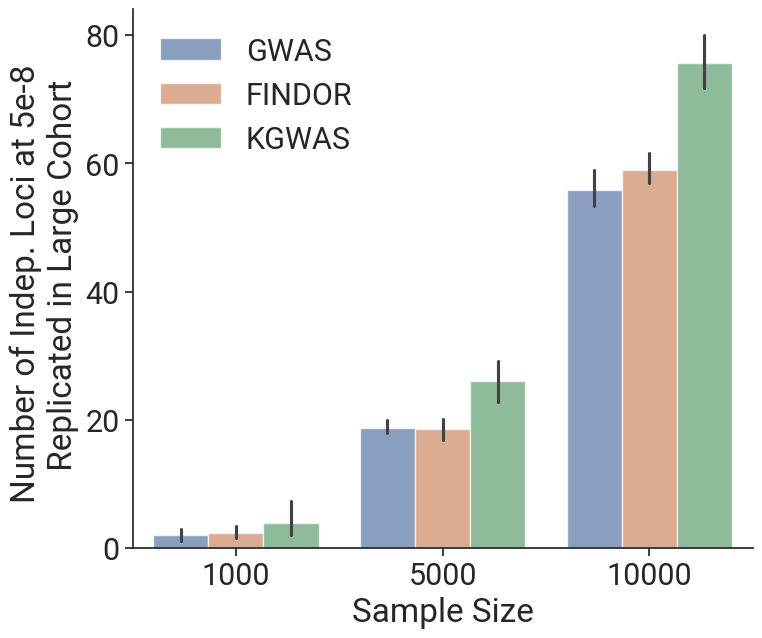

In [12]:
import seaborn as sns
from matplotlib import font_manager
import matplotlib.pyplot as plt
from tqdm import tqdm

font_dirs = ["/dfs/project/datasets/20220524-ukbiobank/data/kgwas_data/misc_data/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
sns.set(rc={'figure.figsize':(8,7)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Roboto", font_scale=2)
plt.rc('axes', unicode_minus=False)

df_res_across_frac = df_res_across_frac.sort_values('# of hits')
ax = sns.barplot(data = df_res_across_frac[df_res_across_frac['sample size'].isin([1000, 5000, 10000])], x = 'sample size', y = '# of hits', 
                 hue = 'Method', hue_order = ['GWAS', 'FINDOR', 'KGWAS'], alpha = 0.7)
ax.set(ylabel = 'Number of Indep. Loci at 5e-8 \n Replicated in Large Cohort', xlabel = 'Sample Size')
legend = plt.legend(frameon=False, loc = 'upper left')
frame = legend.get_frame()
frame.set_facecolor('white')
sns.despine()
plt.savefig("kgwas_sampling_main.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

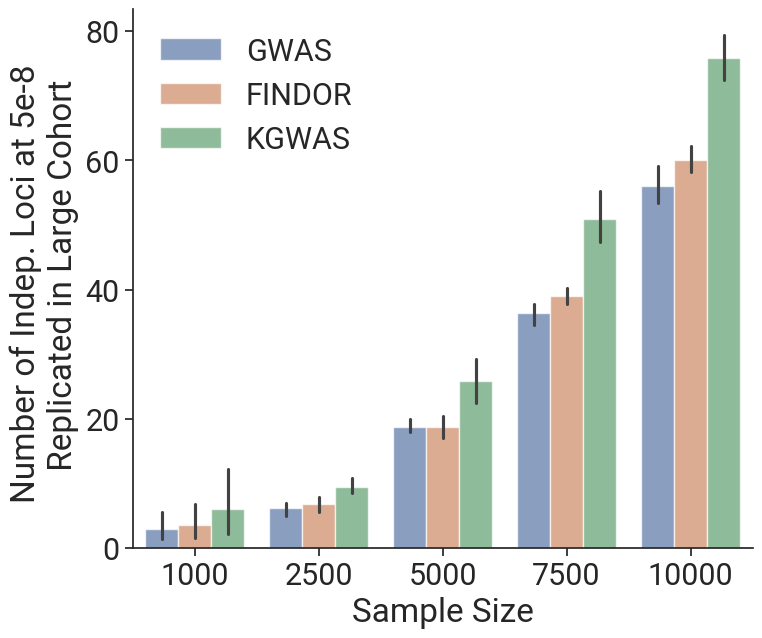

In [28]:
sns.set(rc={'figure.figsize':(8,7)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Roboto", font_scale=2)
plt.rc('axes', unicode_minus=False)

df_res_across_frac = df_res_across_frac.sort_values('# of hits')
ax = sns.barplot(data = df_res_across_frac[df_res_across_frac['sample size'].isin([1000, 2500, 5000, 7500, 10000])], x = 'sample size', y = '# of hits', 
                 hue = 'Method', hue_order = ['GWAS', 'FINDOR', 'KGWAS'], alpha = 0.7)
ax.set(ylabel = 'Number of Indep. Loci at 5e-8 \n Replicated in Large Cohort', xlabel = 'Sample Size')
legend = plt.legend(frameon=False, loc = 'upper left')
frame = legend.get_frame()
frame.set_facecolor('white')
sns.despine()
plt.show()

In [13]:
df_res_sum = df_res_across_frac.groupby(['sample size', 'Method'])['# of hits'].mean().reset_index()
for size in [1000, 2500, 5000, 7500, 10000]:
    for method in ['GWAS', 'FINDOR']:
        kgwas = df_res_sum[(df_res_sum.Method == 'KGWAS') & (df_res_sum['sample size'] == size)]['# of hits'].values[0]
        m = df_res_sum[(df_res_sum.Method == method) & (df_res_sum['sample size'] == size)]['# of hits'].values[0]
        print(f"Method {method} on size {size} with relative improvement {(kgwas - m)/m}")

Method GWAS on size 1000 with relative improvement 1.0
Method FINDOR on size 1000 with relative improvement 0.6666666666666667
Method GWAS on size 2500 with relative improvement 0.5714285714285716
Method FINDOR on size 2500 with relative improvement 0.517241379310345
Method GWAS on size 5000 with relative improvement 0.38297872340425526
Method FINDOR on size 5000 with relative improvement 0.39784946236559127
Method GWAS on size 7500 with relative improvement 0.38461538461538464
Method FINDOR on size 7500 with relative improvement 0.31937172774869094
Method GWAS on size 10000 with relative improvement 0.3548387096774193
Method FINDOR on size 10000 with relative improvement 0.2813559322033897


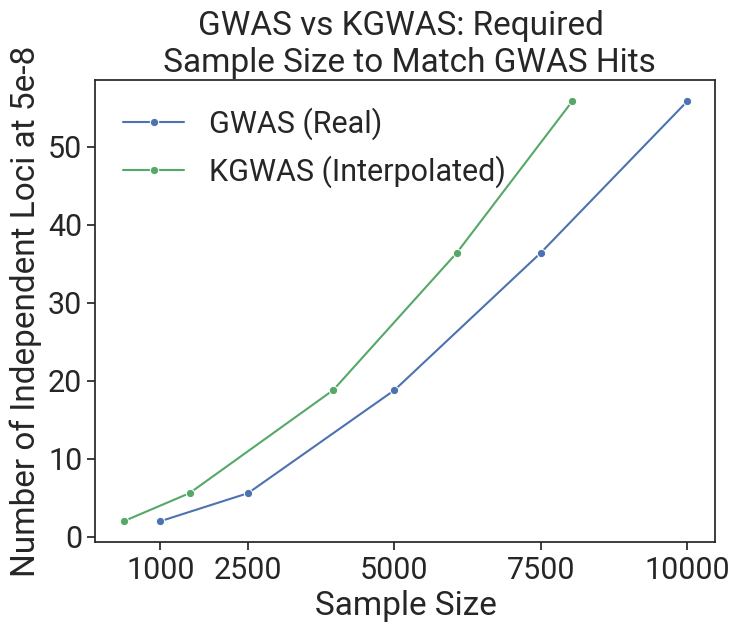

In [14]:
df = pd.DataFrame(df_res_across_frac.groupby(['Method', 'sample size'])['# of hits'].mean()).reset_index()

current_palette = sns.color_palette()
first_color = current_palette[0]
second_color = current_palette[1]
third_color = current_palette[2]

from scipy import interpolate
sns.set(rc={'figure.figsize':(8,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Roboto", font_scale=2)
plt.rc('axes', unicode_minus=False)

# Extracting the data for KGWAS and GWAS
kgwas_data = df[df['Method'] == 'KGWAS']
gwas_data = df[df['Method'] == 'GWAS']
x_kgwas = kgwas_data['sample size']
y_kgwas = kgwas_data['# of hits']
x_gwas = gwas_data['sample size']
y_gwas = gwas_data['# of hits']

# Using linear interpolation for GWAS to estimate sample sizes based on KGWAS hits
gwas_linear_interp = interpolate.interp1d(y_gwas, x_gwas, fill_value="extrapolate")

# Estimating the GWAS sample sizes for KGWAS real number of hits using linear interpolation
gwas_sample_size_for_kgwas_hits_linear = gwas_linear_interp(y_kgwas)

# Using linear interpolation for KGWAS to estimate sample sizes based on GWAS hits
kgwas_linear_interp = interpolate.interp1d(y_kgwas, x_kgwas, fill_value="extrapolate")

# Estimating the KGWAS sample sizes for GWAS real number of hits using linear interpolation
kgwas_sample_size_for_gwas_hits_linear = kgwas_linear_interp(y_gwas)

sns.lineplot(x=x_gwas, y=y_gwas, marker='o', label='GWAS (Real)', color=first_color)

# Plot estimated KGWAS sample sizes for matching GWAS hits using seaborn
sns.lineplot(x=kgwas_sample_size_for_gwas_hits_linear, y=y_gwas, marker='o', label='KGWAS (Interpolated)', color=third_color)

plt.title('GWAS vs KGWAS: Required \n Sample Size to Match GWAS Hits')
plt.xlabel('Sample Size')
plt.ylabel('Number of Independent Loci at 5e-8')
plt.legend(title='')
plt.xticks([1000, 2500, 5000, 7500, 10000])

legend = plt.legend(frameon=False, loc = 'upper left')
frame = legend.get_frame()
frame.set_facecolor('white')


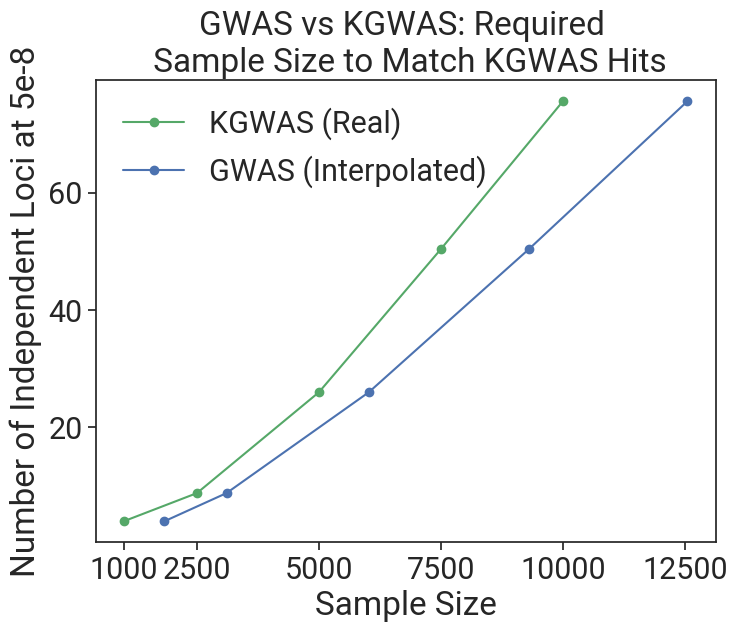

In [15]:
plt.plot(x_kgwas, y_kgwas, 'o-', label='KGWAS (Real)', color=third_color)

# Plot estimated GWAS sample sizes for matching KGWAS hits using linear interpolation
plt.plot(gwas_sample_size_for_kgwas_hits_linear, y_kgwas, 'o-', label='GWAS (Interpolated)', color=first_color)

plt.title('GWAS vs KGWAS: Required \n Sample Size to Match KGWAS Hits')
plt.xlabel('Sample Size')
plt.ylabel('Number of Independent Loci at 5e-8')
plt.legend(title='')
plt.xticks([1000, 2500, 5000, 7500, 10000, 12500])

legend = plt.legend(frameon=False, loc = 'upper left')
frame = legend.get_frame()
frame.set_facecolor('white')
# Show the plot

In [16]:
print(f'Estimated KGWAS required sample sizes at 1K/2.5K/5K/7.5K/10K of GWAS: {kgwas_sample_size_for_gwas_hits_linear}')

Estimated KGWAS required sample sizes at 1K/2.5K/5K/7.5K/10K of GWAS: [ 375.         1500.         3953.48837209 6065.57377049 8035.71428571]


In [17]:
def plot_topk(frac2res_all, query_disease, k = None):
    k_gold = len(seed_res[1][query_disease][1000]['gwas']['mega_clump_gold'])
    df_plot_across_frac = []
    metric = '#Indep. Loci@K, K=' + str(k)
    for frac in frac_list:
        ratio = str(frac)
        for method in method_list:
            df_plot_across_frac.append((method.upper(), frac2res_all[query_disease][frac][method]['recall_k_base_gwas'][k] * k_gold, ratio))
           
    df_plot_across_frac = pd.DataFrame(df_plot_across_frac).rename(columns = {0: 'Method', 1: metric, 2: 'Sampling Ratio'})
    
    return df_plot_across_frac

In [18]:
K = 100
k100_across_diseases_all = {}

for seed in [1,2,3,4,5]:
    frac2res_all = seed_res[seed]
    k100_across_diseases = pd.DataFrame()

    for query_disease in tqdm(frac2res_all.keys()):
        #try:
        k100 = plot_topk(frac2res_all, query_disease, k = K)
        k100['Trait'] = query_disease
        k100_across_diseases = k100_across_diseases.append(k100)
        #except:
        #    pass

    k100_across_diseases_all[seed] = k100_across_diseases

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 762.57it/s]


In [19]:
pivot_df_all_trait = pd.DataFrame()
pivot_df_all = pd.DataFrame()
for i, k100_across_diseases in k100_across_diseases_all.items():
    k100_across_diseases['seed'] = i
    pivot_df = k100_across_diseases.pivot(index=['Sampling Ratio', 'Trait'], columns='Method', values='#Indep. Loci@K, K=' + str(K))

    # Calculating the relative improvement
    pivot_df['Best_Baseline'] = np.maximum(pivot_df['FINDOR'].values, pivot_df['GWAS'].values)
    pivot_df['Relative Improvement (%)'] = ((pivot_df['KGWAS'] - pivot_df['GWAS']) / pivot_df['GWAS']) * 100
    pivot_df['Relative Improvement (%) FINDOR'] = ((pivot_df['FINDOR'] - pivot_df['GWAS']) / pivot_df['GWAS']) * 100
    pivot_df['Relative Improvement (%) Best Baseline'] = ((pivot_df['KGWAS'] - pivot_df['Best_Baseline']) / pivot_df['Best_Baseline']) * 100

    # Resetting index for better readability
    pivot_df.reset_index(inplace=True)


    pivot_df = pivot_df[pivot_df.GWAS != 0]
    pivot_df['Trait (abbr)'] = pivot_df['Trait'].apply(lambda x: id2name[x])
    pivot_df["Sampling Ratio"] = pivot_df["Sampling Ratio"].astype(int)
    pivot_df["Relative Improvement (%)"] = pivot_df["Relative Improvement (%)"]/100
    pivot_df["Relative Improvement (%) Best Baseline"] = pivot_df["Relative Improvement (%) Best Baseline"]/100
    pivot_df["Relative Improvement (%) FINDOR"] = pivot_df["Relative Improvement (%) FINDOR"]/100

    pivot_df_temp = pivot_df
    #pivot_df[~pivot_df['Trait (abbr)'].isin(['TBIL', 'VD', 'PHO', 'MNR', 'HT', 'BMI', 'WBC', 'BALD'])]

    pivot_df_temp['Trait (medium)'] = pivot_df_temp['Trait'].apply(lambda x: id2name_longer[x])
    
    pivot_df_temp['Sampling Ratio'] = pivot_df_temp['Sampling Ratio'].astype(int)
    pivot_df_temp = pivot_df_temp.sort_values('Sampling Ratio')
    pivot_df_temp['Sampling Ratio'] = pivot_df_temp['Sampling Ratio'].astype(str)
    pivot_df_temp['Relative Improvement (%)']*=100
    pivot_df_temp['Relative Improvement (%) FINDOR']*=100
    pivot_df_temp['Relative Improvement (%) GWAS']=0
    pivot_df_temp = pivot_df_temp[pivot_df_temp['Sampling Ratio'].astype(float) >= 1000]
    pivot_df_temp['seed'] = i

    pivot_df_all_trait = pivot_df_all_trait.append(pivot_df_temp)
    pivot_df_temp = pivot_df_temp.groupby(['Sampling Ratio'])[['Relative Improvement (%)', 'Relative Improvement (%) FINDOR', 'Relative Improvement (%) GWAS']].agg(np.mean).reset_index()
    pivot_df_all = pivot_df_all.append(pivot_df_temp)

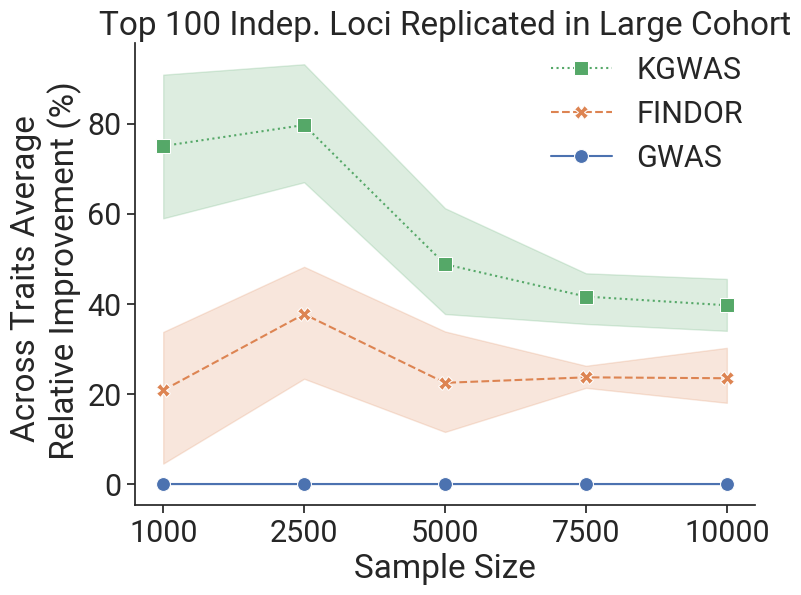

In [20]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Roboto", font_scale=2)
plt.rc('axes', unicode_minus=False)

pivot_df_all = pivot_df_all.reset_index()
pivot_df_all['Sampling Ratio'] = pivot_df_all['Sampling Ratio'].astype(int)
pivot_df_all = pivot_df_all.sort_values(['Sampling Ratio'])
pivot_df_all['Sampling Ratio'] = pivot_df_all['Sampling Ratio'].astype(str)

plt.figure()
g = sns.lineplot(data = pivot_df_all, x = 'Sampling Ratio', 
                 y = 'Relative Improvement (%)', 
                 markersize = 10, marker = 's',linestyle = ':',  label = 'KGWAS', color = third_color)

g = sns.lineplot(data = pivot_df_all, x = 'Sampling Ratio', 
                 y = 'Relative Improvement (%) FINDOR', 
                 markersize = 10,marker = 'X',linestyle = '--', label = 'FINDOR', color = second_color)

g = sns.lineplot(data = pivot_df_all, x = 'Sampling Ratio', 
                 y = 'Relative Improvement (%) GWAS', 
                 markersize = 10,marker = 'o',linestyle = '-', label = 'GWAS', color = first_color)

g.set(xlabel = 'Sample Size', ylabel = 'Across Traits Average \n Relative Improvement (%)', title = 'Top 100 Indep. Loci Replicated in Large Cohort')

sns.despine()
legend = plt.legend(frameon=False, loc='upper right', borderaxespad=0)

frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

In [21]:
pivot_df_all.groupby('Sampling Ratio')['Relative Improvement (%)'].mean()

Sampling Ratio
1000     75.035979
10000    39.707777
2500     79.700424
5000     48.805510
7500     41.634301
Name: Relative Improvement (%), dtype: float64

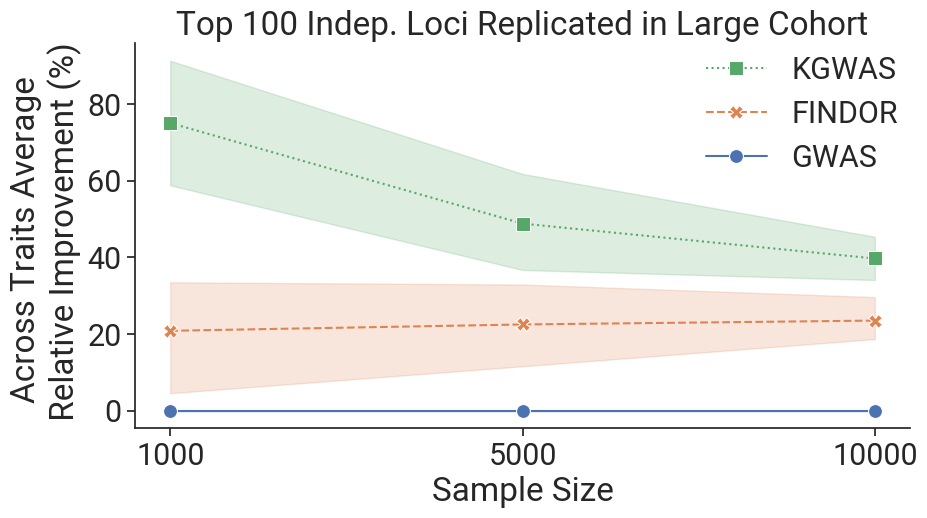

In [33]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Roboto", font_scale=2)
plt.rc('axes', unicode_minus=False)

plt.figure()
g = sns.lineplot(data = pivot_df_all[pivot_df_all['Sampling Ratio'].isin(['1000', '5000', '10000'])], x = 'Sampling Ratio', 
                 y = 'Relative Improvement (%)', 
                 markersize = 10, marker = 's',linestyle = ':',  label = 'KGWAS', color = third_color)

g = sns.lineplot(data = pivot_df_all[pivot_df_all['Sampling Ratio'].isin(['1000', '5000', '10000'])], x = 'Sampling Ratio', 
                 y = 'Relative Improvement (%) FINDOR', 
                 markersize = 10,marker = 'X',linestyle = '--', label = 'FINDOR', color = second_color)

g = sns.lineplot(data = pivot_df_all[pivot_df_all['Sampling Ratio'].isin(['1000', '5000', '10000'])], x = 'Sampling Ratio', 
                 y = 'Relative Improvement (%) GWAS', 
                 markersize = 10,marker = 'o',linestyle = '-', label = 'GWAS', color = first_color)

g.set(xlabel = 'Sample Size', ylabel = 'Across Traits Average \n Relative Improvement (%)', title = 'Top 100 Indep. Loci Replicated in Large Cohort')

sns.despine()
legend = plt.legend(frameon=False, loc='upper right', borderaxespad=0)

frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig("kgwas_top_k_main.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
pivot_df_all.groupby('Sampling Ratio').agg(np.mean)

Method,index,Relative Improvement (%),Relative Improvement (%) FINDOR,Relative Improvement (%) GWAS
Sampling Ratio,,,,
1000,0.0,75.035979,20.851836,0.0
10000,1.0,39.707777,23.516556,0.0
2500,2.0,79.700424,37.739636,0.0
5000,3.0,48.805510,22.503181,0.0
7500,4.0,41.634301,23.718663,0.0


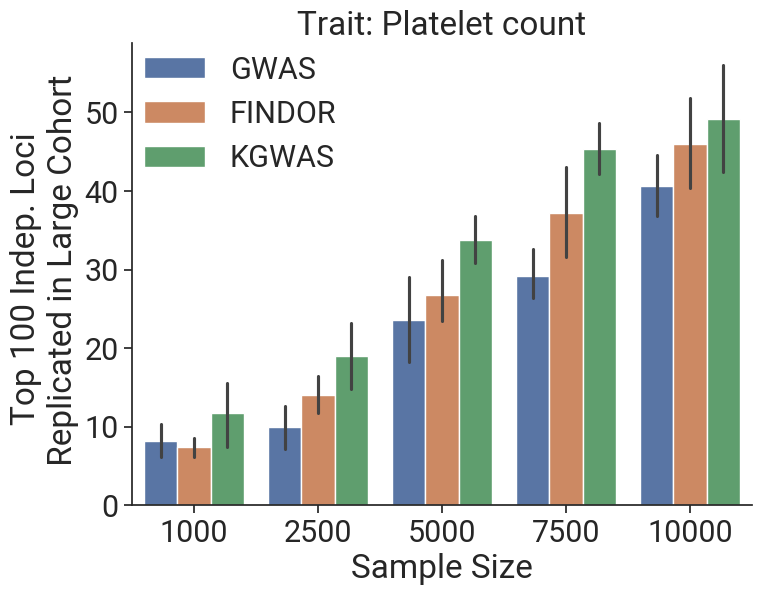

In [23]:
single_trait = pd.DataFrame()
for i, k100_across_diseases in k100_across_diseases_all.items():
    single_trait = single_trait.append(k100_across_diseases[k100_across_diseases.Trait == '30080'])
    
g = sns.barplot(data = single_trait[single_trait['Sampling Ratio'].astype(float)>=1000], 
            x = 'Sampling Ratio', y = '#Indep. Loci@K, K=100', hue = 'Method')

g.set(xlabel = 'Sample Size', ylabel = 'Top 100 Indep. Loci \n Replicated in Large Cohort', title = 'Trait: Platelet count')

sns.despine()
#legend = plt.legend(frameon=False, loc = 'upper right')
legend = plt.legend(frameon=False,
                loc='upper left', borderaxespad=0)

frame = legend.get_frame()
frame.set_facecolor('white')

In [35]:
def plot_pr_curve(query_disease, frac, frac2res_all):
    frac2res = frac2res_all[query_disease][frac]

    def flatten(l):
        return [item for sublist in l for item in sublist]
    df_recall_at_prec = []    
    mega_clump_gold = seed_res[1][query_disease][1000]['gwas']['mega_clump_gold']

    for prec in np.arange(0, 1.01, 0.01):
        recall_at_prec_frac = {}

        for method in method_list:

            prec_k_list = [i for i,j in frac2res[method]['precision_k_base_gwas'].items() if j >= prec]
            if len(prec_k_list) > 0:
                recall_at_prec_frac[method.upper()] = len([mega_clump_gold[i] for i in frac2res[method]['k_to_clump_idx_base_gwas'][max(prec_k_list)]])
            else:
                recall_at_prec_frac[method.upper()] = 0


        for x in [i.upper() for i in method_list]:
            df_recall_at_prec.append((prec, x, recall_at_prec_frac[x]))

    df_recall_at_prec = pd.DataFrame(df_recall_at_prec).rename(columns = {0: 'Precision', 1: 'method', 2: '# of Indep Loci Found'})

    to_report = df_recall_at_prec[df_recall_at_prec.Precision >= 0.2]
    ax = sns.lineplot(data = to_report, x = 'Precision', y='# of Indep Loci Found', 
                      hue = 'method', style='method', hue_order = ['GWAS', 'FINDOR', 'KGWAS'], markers=True)
    ax.set(title = id2name[query_disease], xlabel = 'Replication Rate of Retrieved Indep. Loci', ylabel = '# Indep. Loci Replicated at Large Cohort')
    legend = plt.legend(frameon=False, loc = 'upper right')
    frame = legend.get_frame()
    sns.despine()
    frame.set_facecolor('white')
    plt.show()

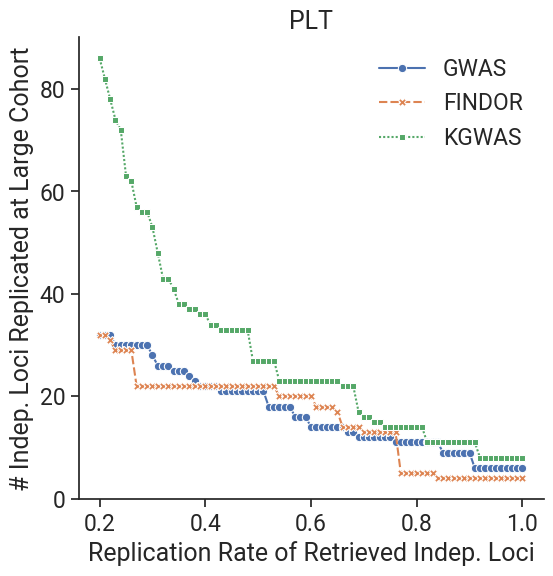

In [26]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Roboto", font_scale=1.5)
plt.rc('axes', unicode_m
       inus=False)

plot_pr_curve('30080', 5000, seed_res[1])

In [27]:
pivot_df_temp = pivot_df_all_trait[pivot_df_all_trait.seed == 1]
cmap = sns.diverging_palette(230, 20, as_cmap=True)
pivot_df_temp.loc[:, "Sampling Ratio"] = pivot_df_temp["Sampling Ratio"].astype(int)

order = ['1000', '2500', '5000', '7500','10000']

pivot_df_temp.loc[:, "Relative Improvement (%)"] = pivot_df_temp["Relative Improvement (%)"]/100
pivot_df_temp.loc[:, "Relative Improvement (%) Best Baseline"] = pivot_df_temp["Relative Improvement (%) Best Baseline"]/100
pivot_df_temp.loc[:, "Relative Improvement (%) FINDOR"] = pivot_df_temp["Relative Improvement (%) FINDOR"]/100

/dfs/user/kexinh/miniconda3/envs/a100_env/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


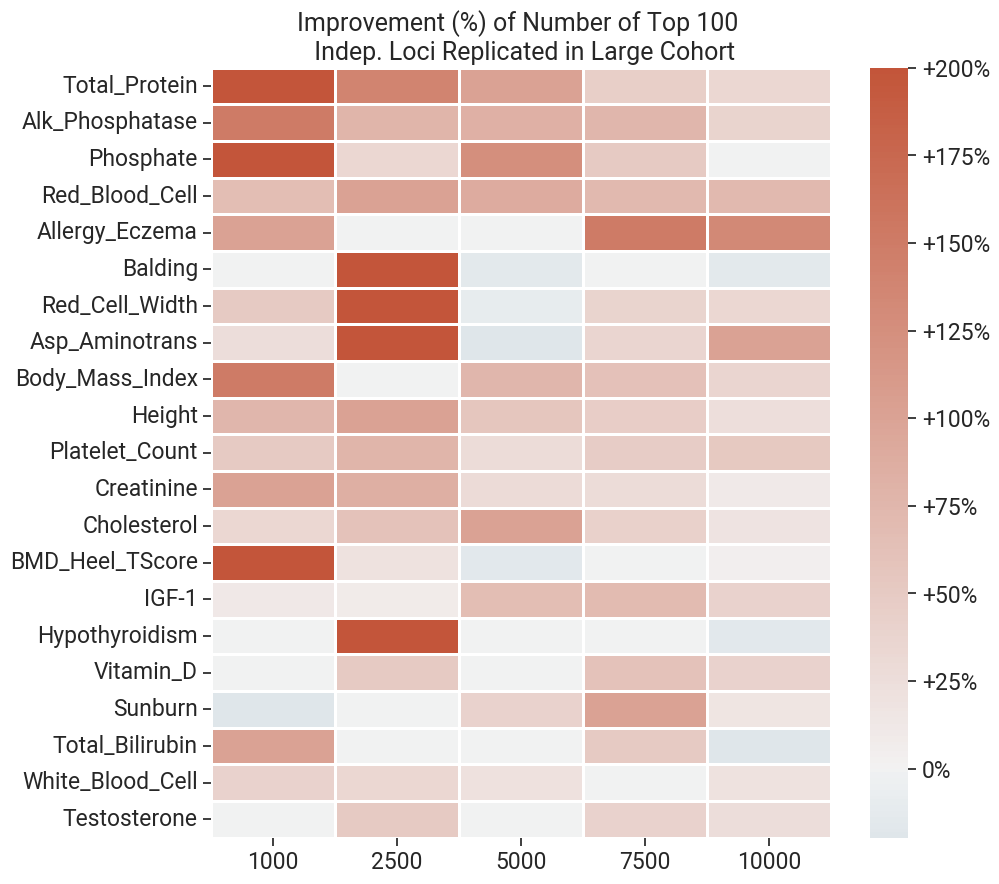

In [28]:
def custom_format(x):
    if x > 0:
        return f"+{x:.2%}"
    else:
        return f"{x:.2%}"
heatmap = pivot_df_temp.pivot(index="Trait (medium)", columns="Sampling Ratio", values="Relative Improvement (%)").replace([np.inf, -np.inf, np.nan], 0)
f, ax = plt.subplots(figsize=(10,10))
heatmap['row_sum'] = heatmap.sum(axis=1)
heatmap.sort_values(by='row_sum', ascending=False, inplace=True)
heatmap.drop(columns='row_sum', inplace=True)

#heatmap_small = heatmap[['1000', '5000', '10000']]
g = sns.heatmap(heatmap, annot=False, fmt=".1%", linewidths=1, robust=True, cmap=cmap, center=0, vmax=2.0, ax = ax)

colorbar = g.collections[0].colorbar

# Format tick labels as percentages
colorbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
colorbar.set_ticklabels(['0%', '+25%','+50%','+75%', \
                         '+100%', '+125%', '+150%', '+175%', '+200%'])

g.set(xlabel = '', ylabel = '', title = 'Improvement (%) of Number of Top 100 \n Indep. Loci Replicated in Large Cohort')
ax = plt.gca()

# Move the X-axis to the top
#ax.xaxis.tick_top()
#ax.xaxis.set_label_position('top') 
#plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()